<a href="https://colab.research.google.com/github/yusufraji/ai-anomaly-detector-ml-1/blob/main/notebooks/rule_engine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This notebook creates rule based anomaly detection based on domain knowledge provided by the dataset provider

Some of the rules we will look into are:


*   **Dormant state**: more than two drives can be assigned to the same train. However, only maximum of two drives are required to carry the payload. An anomaly would be a case where only one drive is running when more drives are assigned to the train
*   **Sluggish state**: multiple drives assigned to the same train should have almost equal torque. The moving average of two drive's torque shouldn't be highly deviated. Here, a thresholding of the deviation will be used to detect a sluggish drive
*   **Inactive state**: this state detects when a motor should be running, but isn't. If a motor has velocity and doesn't produce any torque for a certain period of time, this behaviour is anomalous and should be detected







# Preamble

In [1]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import animation
from collections import Counter
from datetime import datetime, timezone

In [3]:
project_root_dir = Path.cwd() / 'drive' / 'My Drive' / 'applied-data-hackathon' / 'predictive-maintenance'

In [4]:
def getNowTime():
       return int(datetime.now(tz=timezone.utc).timestamp() * 1000)
nowtime = getNowTime()

# Load data

note: number of assigned cannot be more that 1 and at the same time, have number of running to be less than 2. if (n_assigned>1): anomaly if n_running<2

In [5]:
df = pd.read_csv(project_root_dir/"total_data.csv", index_col=[0])

In [6]:
# to get the time in seconds, 
# subtract the last timestamp from the first one, then
# divide the sequence length by the time difference to obtain time duration for each time step
# multiply by 60 to get the time in minutes
time_per_step =  (df["key"].iloc[-1] - df["key"].iloc[0]) / (len(df["key"]) - 1)
# assuming the time_per_step unit is microsecond, the signal is ~8 minutes long
# time_per_second(~5000)*(100000)=500000000us=8.3minutes 
time_min = time_per_step/(60*1e6)
df["time(m)"] = df.apply(lambda x: x.name*time_min, axis=1)

In [7]:
df

,key,drive1_velocity,drive1_gear,drive1_torque,drive2_gear,drive3_gear,drive4_gear,drive5_gear,drive6_gear,drive2_velocity,drive3_velocity,drive4_velocity,drive5_velocity,drive6_velocity,drive2_torque,drive3_torque,drive4_torque,drive5_torque,drive6_torque,time(m)
0,18504866,-0.00002,3.0,0.000,3.0,3.0,2.0,1.0,3.0,50.02526,49.74947,49.94469,49.92781,-0.00007,0.231,0.242,0.196,0.292,0.000,0.000000
1,18509861,0.00001,3.0,0.000,3.0,3.0,2.0,1.0,3.0,49.87878,49.67910,49.96670,49.96341,0.00000,0.232,0.242,0.184,0.269,0.000,0.000083
2,18514857,0.00002,3.0,0.000,3.0,3.0,2.0,1.0,3.0,49.85296,49.66757,49.84562,49.90190,0.00000,0.258,0.275,0.204,0.301,0.000,0.000167
3,18519857,-0.00001,3.0,0.000,3.0,3.0,2.0,1.0,3.0,49.65267,49.62158,50.17581,50.15014,0.00004,0.279,0.289,0.188,0.270,0.000,0.000250
4,18524866,0.00000,3.0,0.000,3.0,3.0,2.0,1.0,3.0,49.79240,49.92024,50.21992,50.09853,0.00001,0.304,0.295,0.165,0.282,0.000,0.000333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,518479862,50.08721,1.0,0.252,3.0,3.0,3.0,3.0,2.0,0.00013,-0.00007,49.81332,49.63741,50.39635,0.000,0.000,0.200,0.216,0.170,8.332917
99996,518484870,50.16852,1.0,0.260,3.0,3.0,3.0,3.0,2.0,0.00017,-0.00005,49.83447,49.79659,50.07809,0.000,0.000,0.195,0.246,0.155,8.333000
99997,518489864,50.05760,1.0,0.235,3.0,3.0,3.0,3.0,2.0,-0.00008,0.00025,49.88919,49.86397,49.73057,0.000,0.000,0.210,0.230,0.195,8.333083
99998,518494859,50.01374,1.0,0.259,3.0,3.0,3.0,3.0,2.0,-0.00002,-0.00025,50.08526,49.93999,49.61115,0.000,0.000,0.184,0.252,0.211,8.333167


# Compute Bollinger bands

In [8]:
for k in df[[k for k in df.columns if "torque" in k]].columns:
  df[f"{k}_sma"] = df[k].rolling(50).mean()
  df[f"{k}_std"] = df[k].rolling(50).std()
  df[f"{k}_bollinger_upper"] = df[f"{k}_sma"] + df[f"{k}_std"] * 2   # calculate upper band
  df[f"{k}_bollinger_lower"] = df[f"{k}_sma"] - df[f"{k}_std"] * 2   # calculate lower band


# Dormant state

In [9]:
# check if the motor is running based on rolling window of the velocity value
for k in df[[k for k in df.columns if "velocity" in k]].columns:
  new_key = k.replace("velocity", "running")
  df[new_key] = (df[k].rolling(50).mean() > 10).astype(int)

In [10]:
# combine all the running values to a single list
columns = ["drive1_running", "drive2_running", "drive3_running", "drive4_running", "drive5_running", "drive6_running"]
df["running"] = df[columns].values.tolist()

In [11]:
# combine all drive gear poistions to a single list
columns = ["drive1_gear", "drive2_gear", "drive3_gear", "drive4_gear", "drive5_gear", "drive6_gear"]
df["drive_gears"] = df[columns].values.tolist()

In [12]:
# count the number of motors assigned to a particular train
df["n_assigned"] = df["drive_gears"].apply(lambda x: dict(Counter(x)))

In [13]:
# determines number of machines are actually running on which train this time step
# returns a dictionary with key=gear, and value=number of motors running on that gear
def running_on(row):
  running_on = {}
  for idx, val in enumerate(row["running"], start=1):
    if val:
      key = row[f"drive{idx}_gear"]
      # Use dict.get(key, 0) to get the current value of key in dict, 
      # if key is present in dict, and otherwise return 0. 
      # Then, assign dict[key] to 1 plus the result of dict.get().
      # running_on[key] = running_on.get(key, 0) + 1
      running_on.setdefault(key, []).append(f"drive{idx}_gear")

  return running_on

In [14]:
df["running_on"] = df.apply(lambda x: running_on(x), axis=1)

In [15]:
def dormant_check(row):
  dormant_status = 0
  dormant_report = []
  if row["running_on"]:
    for k, v in row["running_on"].items():
      # dormant if more than 2 drives are assinged, but less than 2 are actually
      # running
      n_assigned = row["n_assigned"][k]
      if (n_assigned > 2) & (len(v)<2):
        dormant_status = 1
        dormant_report.append(f"{n_assigned} drives assinged to gear {k}, only {v} drive(s) running now")
  return dormant_status, dormant_report


In [16]:
df[["dormant_status", "dormant_report"]] = df.apply(lambda x: dormant_check(x), axis=1, result_type="expand")

In [17]:
df[["dormant_status", "dormant_report"]][df["dormant_status"] == 1]

,dormant_status,dormant_report
6083,1,"[3 drives assinged to gear 3.0, only ['drive3_..."
6084,1,"[3 drives assinged to gear 3.0, only ['drive3_..."
6085,1,"[3 drives assinged to gear 3.0, only ['drive3_..."
6086,1,"[3 drives assinged to gear 3.0, only ['drive3_..."
6087,1,"[3 drives assinged to gear 3.0, only ['drive3_..."
...,...,...
89050,1,"[4 drives assinged to gear 3.0, only ['drive4_..."
89051,1,"[4 drives assinged to gear 3.0, only ['drive4_..."
89052,1,"[4 drives assinged to gear 3.0, only ['drive4_..."
89053,1,"[4 drives assinged to gear 3.0, only ['drive4_..."


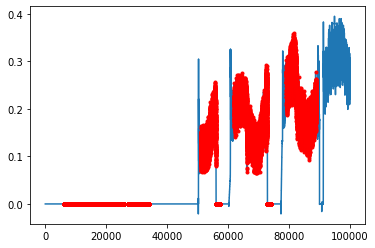

In [18]:
df["drive1_torque"].plot()
df["drive1_torque"][df["dormant_status"] == 1].plot(style='r.')

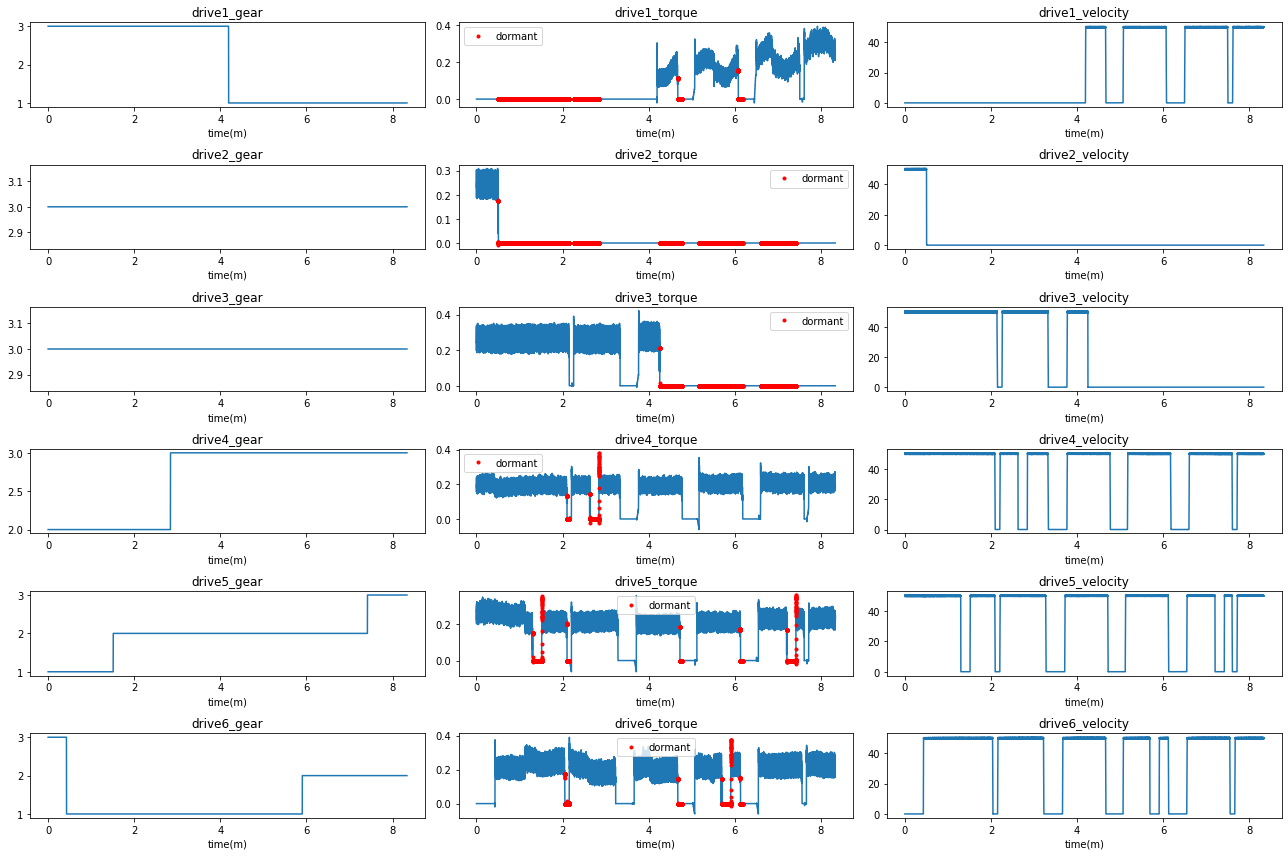

In [19]:
keys = ["drive1_gear", "drive1_torque", "drive1_velocity",
        "drive2_gear", "drive2_torque", "drive2_velocity",
        "drive3_gear", "drive3_torque", "drive3_velocity",
        "drive4_gear", "drive4_torque", "drive4_velocity",
        "drive5_gear", "drive5_torque", "drive5_velocity",
        "drive6_gear", "drive6_torque", "drive6_velocity"
        ]
fig, axes = plt.subplots(6, 3, figsize=(18, 12))
df_temp = df.copy(deep=True)
df_temp.set_index("time(m)", inplace=True)
for (key, ax) in zip(keys, axes.flatten()):

  ax.plot(df_temp[key])
  if "torque" in key:
    drive_running_key = key.replace("torque", "running")
    ax.plot(df_temp[key][(df_temp["dormant_status"] == 1) & (df_temp[drive_running_key] == 0)], 'r.', label="dormant")
    ax.legend()
  ax.title.set_text(key)
  ax.set_xlabel("time(m)")
plt.tight_layout()

del df_temp

In [20]:
# # to get the time in seconds, 
# # subtract the last timestamp from the first one, then
# # divide the sequence length by the time difference to obtain time duration for each time step
# # multiply by 60 to get the time in minutes
# time_per_step =  (df["key"].iloc[-1] - df["key"].iloc[0]) / (len(df["key"]) - 1)
# # assuming the time_per_step unit is microsecond, the signal is ~8 minutes long
# # time_per_second(~5000)*(100000)=500000000us=8.3minutes 
# time_min = time_per_step/(60*1e6)
# df["time_min"] = df.apply(lambda x: x.name*time_min, axis=1)

# Sluggish state

<Figure size 1152x1440 with 0 Axes>

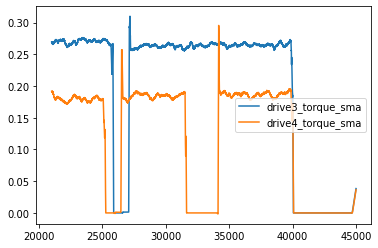

In [21]:
fig = plt.figure(figsize=(16, 20))
# df.loc[21000:45000, ["drive3_torque_sma", "drive4_torque_sma", "drive3_torque_bollinger_upper", "drive4_torque_bollinger_upper", "drive3_torque_bollinger_lower", "drive4_torque_bollinger_lower"]].plot()
df.loc[21000:45000, ["drive3_torque_sma", "drive4_torque_sma"]].plot()

In [22]:
def sluggish_check(row):
  sluggish_status = {}
  sluggish_report = []
  for k, v in row["running_on"].items():
    if len(v) > 1:
      drives = [val for val in v]
      # check if more that one of the drives are running
      if sum([row[drive.replace("gear", "running")] for drive in drives]) > 1:

        sma = [row[val.replace("gear", "torque_sma")] for val in v]
        # the difference between the torques shouldn't exceed 2 std from the drives torque 
        compare_sma_std = (np.diff(sma).item() > (row[val.replace("gear", "torque_std")] *2) for val in drives)
        if any(list(compare_sma_std)):
          for drive in drives:
            sluggish_status[drive.replace("gear", "torque")] = sluggish_status.get(drive.replace("gear", "torque"), 0) + 1
          drive_torque = [drive.replace('gear', 'torque') for drive in drives]
          sluggish_report.append(f"One of {*drive_torque,} is producing low torque")
  return sluggish_status, sluggish_report

In [23]:
df[["sluggish_status", "sluggish_report"]] = df.apply(lambda x: sluggish_check(x), axis=1, result_type="expand")

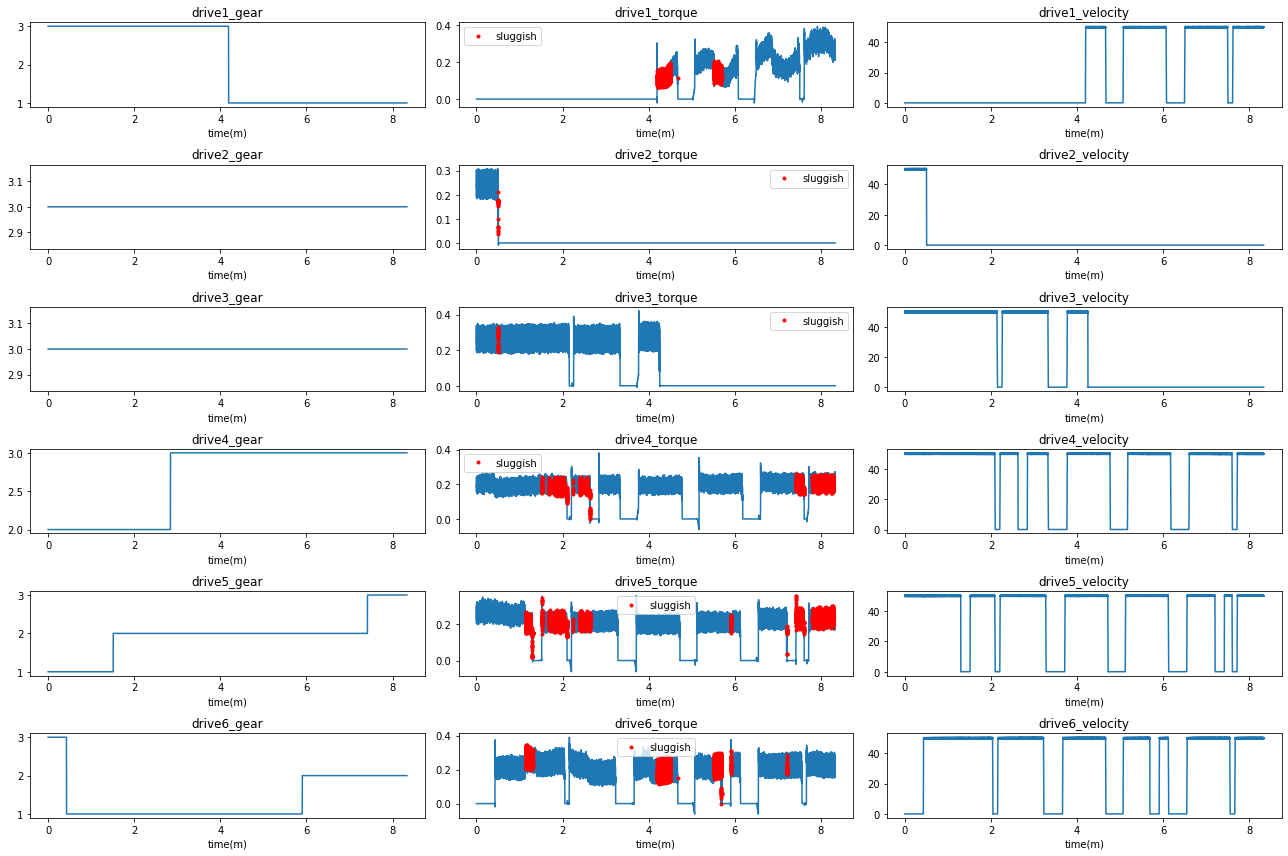

In [24]:
keys = ["drive1_gear", "drive1_torque", "drive1_velocity",
        "drive2_gear", "drive2_torque", "drive2_velocity",
        "drive3_gear", "drive3_torque", "drive3_velocity",
        "drive4_gear", "drive4_torque", "drive4_velocity",
        "drive5_gear", "drive5_torque", "drive5_velocity",
        "drive6_gear", "drive6_torque", "drive6_velocity"
        ]
fig, axes = plt.subplots(6, 3, figsize=(18, 12))
df_temp = df.copy(deep=True)
df_temp.set_index("time(m)", inplace=True)
for (key, ax) in zip(keys, axes.flatten()):

  ax.plot(df_temp[key])
  if "torque" in key:
    drive_running_key = key.replace("torque", "running")
    ax.plot(df_temp[key][(df_temp["sluggish_status"].apply(lambda x: x.get(key, 0)) == 1) & (df_temp[drive_running_key] == 1)], 'r.', label="sluggish")
    ax.legend()
  ax.title.set_text(key)
  ax.set_xlabel("time(m)")
plt.tight_layout()

del df_temp

# Inactive state

In [26]:
keys = ["drive1_torque",
        "drive2_torque",
        "drive3_torque",
        "drive4_torque",
        "drive5_torque",
        "drive6_torque", 
        ]
for k in keys:
  inactive_key = k.replace("torque", "inactive")
  running_key = k.replace("torque", "running")
  df[inactive_key] = (df[running_key] > (df[k].rolling(50).mean() > 0.1).astype(int)).astype(int)

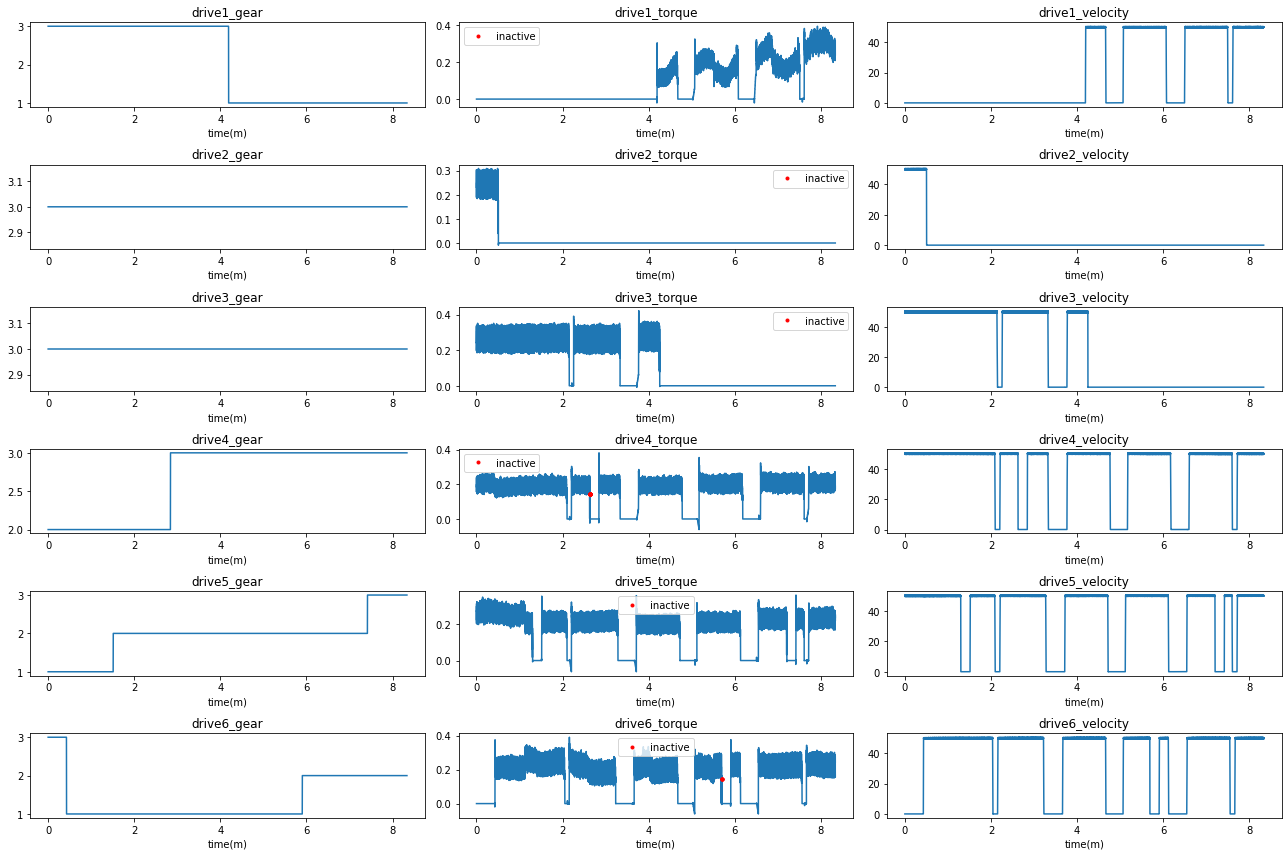

In [27]:
keys = ["drive1_gear", "drive1_torque", "drive1_velocity",
        "drive2_gear", "drive2_torque", "drive2_velocity",
        "drive3_gear", "drive3_torque", "drive3_velocity",
        "drive4_gear", "drive4_torque", "drive4_velocity",
        "drive5_gear", "drive5_torque", "drive5_velocity",
        "drive6_gear", "drive6_torque", "drive6_velocity"
        ]
fig, axes = plt.subplots(6, 3, figsize=(18, 12))
df_temp = df.copy(deep=True)
df_temp.set_index("time(m)", inplace=True)
for (key, ax) in zip(keys, axes.flatten()):

  ax.plot(df_temp[key])
  if "torque" in key:
    drive_inactive_key = key.replace("torque", "inactive")
    ax.plot(df_temp[key][(df_temp[drive_inactive_key] == 1)], 'r.', label="inactive")
    ax.legend()
  ax.title.set_text(key)
  ax.set_xlabel("time(m)")
plt.tight_layout()

del df_temp

## Inactive simulation

In [49]:
df_bad = df.copy(deep=True)
keys = ["drive1_torque",
        "drive2_torque",
        "drive3_torque",
        "drive4_torque",
        "drive5_torque",
        "drive6_torque", 
        ]
for k in keys:
  # zero some of the torque values
  df_bad.loc[25000:35000, k] = 0
  inactive_key = k.replace("torque", "inactive")
  running_key = k.replace("torque", "running")
  df_bad[inactive_key] = (df_bad[running_key] > (df_bad[k].rolling(50).mean() > 0.1).astype(int)).astype(int)

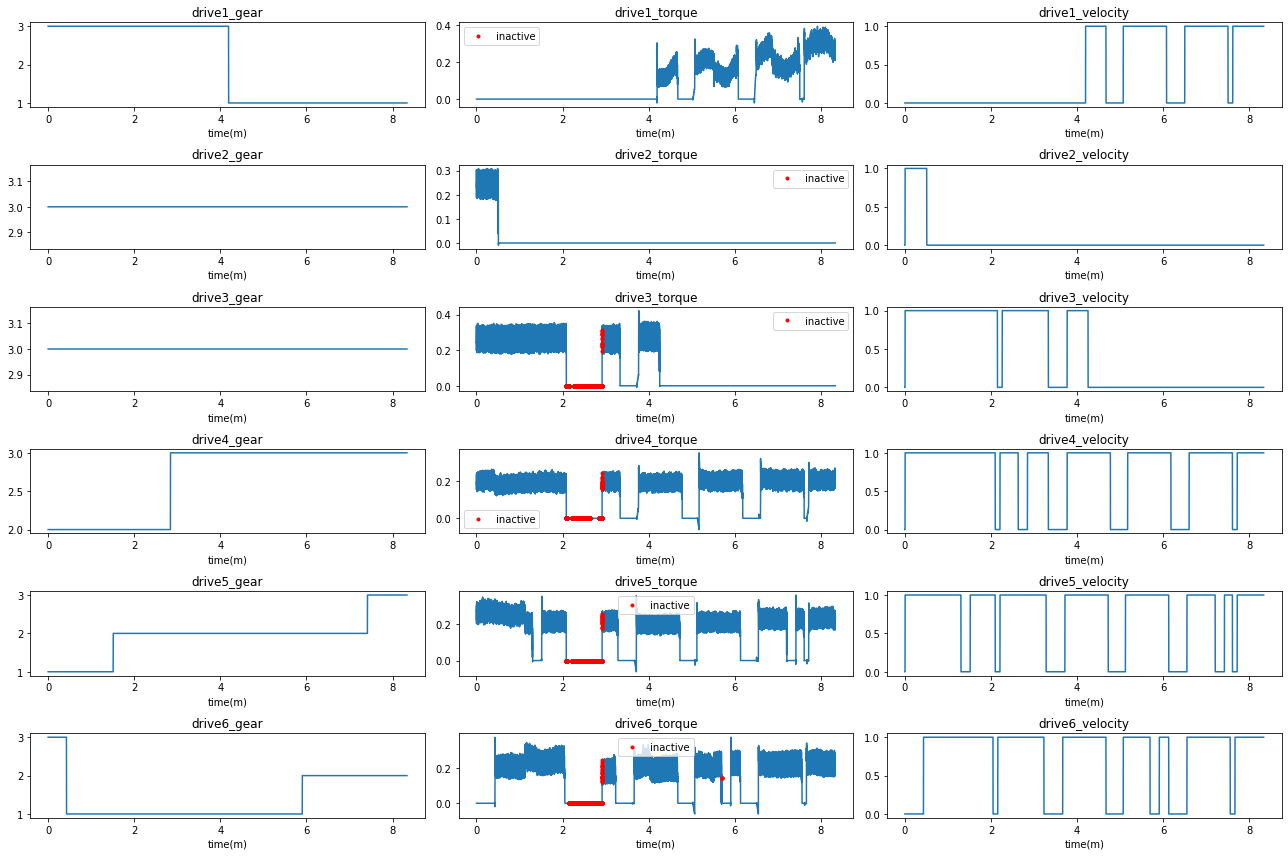

In [50]:
keys = ["drive1_gear", "drive1_torque", "drive1_velocity",
        "drive2_gear", "drive2_torque", "drive2_velocity",
        "drive3_gear", "drive3_torque", "drive3_velocity",
        "drive4_gear", "drive4_torque", "drive4_velocity",
        "drive5_gear", "drive5_torque", "drive5_velocity",
        "drive6_gear", "drive6_torque", "drive6_velocity"
        ]
fig, axes = plt.subplots(6, 3, figsize=(18, 12))
df_temp = df_bad.copy(deep=True)
df_temp.set_index("time(m)", inplace=True)

for (key, ax) in zip(keys, axes.flatten()):

  ax.plot(df_temp[key])
  if "torque" in key:
    drive_inactive_key = key.replace("torque", "inactive")
    ax.plot(df_temp[key][(df_temp[drive_inactive_key] == 1)], 'r.', label="inactive")
    ax.legend()
  ax.title.set_text(key)
  ax.set_xlabel("time(m)")
plt.tight_layout()

del df_temp

# Animation

In [31]:
# keys = ["drive1_torque",
#         "drive2_torque",
#         "drive3_torque",
#         "drive4_torque",
#         "drive5_torque",
#         "drive6_torque",
#         ]
# fig, axes = plt.subplots(6, 1, figsize=(18, 12))
# df_temp = df[:5].copy(deep=True)
# df_temp.set_index("time(m)", inplace=True)

# lines = []
# x_data = []
# for idx, ax in enumerate(axes.flatten()):
#   globals()[f"line_{idx}"] = ax.plot([], [])[0]
#   globals()[f"y{idx}_data"] = []
#   globals()[f"y{idx}_dormant_data"] = []

#   lines.append(globals()[f"line_{idx}"])

# def animate(i):
#   print(i)
#   for idx, (key, ax) in enumerate(zip(keys, axes.flatten())):
#     # update the data
#     x_data.append(df_temp.index[0])
#     globals()[f"y{idx}_data"].append(df_temp[key])

#     # lines[idx], = ax.plot(df_temp.index[idx].astype(float), df_temp.loc[idx,key].astype(float))
#     if ("torque" in key):
#       drive_running_key = key.replace("torque", "running")
#       dormant = df_temp.loc[i, key][(df_temp.loc[i, "dormant_status"] == 1) & (df_temp.loc[i, drive_running_key] == 0)]
#       if (dormant.size > 0):
#         globals()[f"y{idx}_dormant_data"].append()
#         lines[idx] = ax.plot(df_temp.index[idx], dormant, 'r.', label="dormant")
#   #     ax.legend()
#   #   ax.title.set_text(key)
#   #   ax.set_xlabel("time(m)")
#     globals()[f"line_{idx}"].set_data(x_data, globals()[f"y{idx}_data"])
#   # plt.tight_layout()
  
#   return lines

# anim = animation.FuncAnimation(fig, animate, frames=np.arange(len(df_temp)+1), interval = 1, blit = False)
# Writer = animation.writers['ffmpeg']
# writer = Writer(fps=15, bitrate=1000)
# anim.save(f'{project_root_dir}/dormant_animation.mp4', writer=writer)
# plt.show()

# del df_temp

In [32]:
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib import animation

# df_temp = df[:1000].copy(deep=True)
# # df_temp.set_index("time(m)", inplace=True)


# fig, ax = plt.subplots(1, 1, figsize = (6, 6))

# def animate(i):
#   # ax.cla() # clear the previous image
#   ax.plot(df_temp.loc[:i, "time(m)"], df_temp.loc[:i, "drive2_torque"])
#   # ax.set_text(f'Frame = {i:4d}')
#   # ax.plot(df_temp["drive1_torque"][:i]) # plot the line

# anim = animation.FuncAnimation(fig, animate, frames = len(df_temp), interval = 200, blit = False)
# Writer = animation.writers['ffmpeg']
# writer = Writer(fps=15, bitrate=1000)
# # anim.save(f'{project_root_dir}/animation_test.mp4', writer=writer)
# # plt.show()

In [33]:
# from IPython.display import HTML
# HTML(anim.to_html5_video())

In [34]:
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib import animation

# dt = 0.01
# tfinal = 1
# x0 = 0

# sqrtdt = np.sqrt(dt)
# n = int(tfinal/dt)
# xtraj = np.zeros(n+1, float)
# trange = np.linspace(start=0,stop=tfinal ,num=n+1)
# xtraj[0] = x0

# for i in range(n):
#     xtraj[i+1] = xtraj[i] + np.random.normal()

# x = trange
# y = xtraj

# # animation line plot example

# fig, ax = plt.subplots(1, 1, figsize = (6, 6))

# def animate(i):
#     ax.cla() # clear the previous image
#     ax.plot(x[:i], y[:i]) # plot the line
#     ax.set_xlim([x0, tfinal]) # fix the x axis
#     ax.set_ylim([1.1*np.min(y), 1.1*np.max(y)]) # fix the y axis

# anim = animation.FuncAnimation(fig, animate, frames = len(x) + 1, interval = 300, blit = False)
# # Writer = animation.writers['ffmpeg']
# # writer = Writer(fps=15, bitrate=1000)
# # anim.save(f'{project_root_dir}/animation_test.mp4', writer=writer)
# # plt.show()

In [35]:
# from IPython.display import HTML
# HTML(anim.to_html5_video())